In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
import tracemalloc
from lib.model import LinearRegression, PolynomialRegreesion1D
from lib.optimizeloop import optimize_model, optimize_sum_functions
from lib.optimizer import ConstantStepOptimizer,  DecayStepOptimizer, Momentum, Nesterov, AdaGrad, RMSProp, Adam
from lib.visualize import draw_contour, draw_trajectory

warnings.filterwarnings('ignore')
np.random.seed(43)

In [2]:

def new_page():
    from IPython.display import Latex, display
    display(Latex(r"\newpage"))
    
def round(x, p=2):
    return np.round(x, p) + 0

def format_num(x):
    return "{:g}".format(round(x))

def show_md(text):
    from IPython.display import Markdown, display
    display(Markdown(text))
    
def df_to_markdown(df, index_name=None):
    from IPython.display import Markdown, display
    df.index.name = index_name
    df = df.reset_index() if index_name is not None else df
    fmt = ['---' for _ in range (len (df.columns ))]
    df_fmt = pd.DataFrame ([fmt], columns = df.columns)
    df_formatted = pd.concat ([df_fmt, df])
    display(Markdown(df_formatted.to_csv (sep = "|", index =  False)))

def conv(a):
     return np.convolve(a, np.array([0.15, 0.2, 0.3, 0.2, 0.15]), mode='valid')


# Постановка задачи

1. Реализуйте стохастический градиентный спуск для решения линейной регрессии. И

   Исследуйте сходимость с разным размером батча 
   * 1 - SGD
   * $2 \ldots n - 1$ Minibatch GD
   * n - GD из предыдущей работы
2. Подберите функцию изменения шага (learning rate scheduling), чтобы улучшить сходимость, например экспоненциальную или ступенчатую.

3. Исследуйте модификации градиентного спуска 
    * Nesterov 
    * Momentum 
    * AdaGrad 
    * RMSProp 
    * Adam

4. Исследуйте сходимость алгоритмов. 

   Сравнить различные методы по скорости сходимости, надежности, требуемым машинным ресурсам (объем оперативной памяти, количеству арифметических операций, времени выполнения)
5. Постройте траекторию спуска различных алгоритмов из одной и той же исходной точки с одинаковой точностью. 

   В отчете наложить эту траекторию нарисунок с линиями равного уровня заданной функции.

6. Реализуйте полиномиальную регрессию. 

   Постройте графики восстановленной регрессии для полиномов разной степени.

7. Модифицируйте полиномиальную регрессию добавлением регуляризации в модель (L1, L2, Elastic регуляризации).

8. Исследуйте влияние регуляризации на восстановление регрессии.

# Стохастический и батчевый градиентный спуск

Рассмотрим функцию вида $f(x) = \sum_{i = 1}^{m}{f_i(x)}$ и параметр $BS$ - размер батча.
На каждой итерации градиентного спуска вместо вычисления градиента функции $f(x)$ вычислим градиент функции 

$f'(x) = \sum_{i \in I}{f_i(x)}$, где $I$ - случайное подмножество $\{1, 2 \ldots m\}$ на текущей итерации, размер которого равен $BS$. 

После воспользуемся градиентом функции $f'(x)$ для вычисления точки $x_k$, вместо градиента функции $f(x)$.

Такая разновидность градиентного спуска называется батчевым градиентным спуском c размером батча $BS$. Если $BS = 1$, метод называют стохастическим градиентным спуском.

## Линейная регрессия

Пусть 

$X = (x_1, x_2 \ldots x_m)$ - набор векторов размерности $n$.

$Y = (y_1, y_2 \ldots y_m)$ - набор чисел. 

Задача линейной регрессии заключается в нахождении такого вектора $w$ размерности $n$ и числа $b$, минимизирующей следующую функцию:

$L(w, b) = \sum_{i = 1}^{m}({x_i w + b} - y_i)^2$. Функцию $L$ называют функцией ошибки.

Иными словами, нужно найти $n$-мерную плоскость наилучшим образом аппроксимириющую входные данные.

## Применение градиентного спуска к решению задачи линейной регрессии.

Для решения задачи линейной регрессии, может быть применен батчевый градиентный спуск. В случае линейной регрессии, функция ошибки является суммой слагаемых вида $({x_i w + b} - y_i)^2$, 
а значит можно применить батчевый градиентный спуск, где $f_i = ({x_i w + b} - y_i)^2$. 

Пример решения одномерной линейной регрессии представлен ниже.


In [3]:
def generate_points(c, b, n, m, noise=0.5):
    X = np.random.rand(m, n)
    Y = np.random.uniform(low=-noise, high=noise, size=(m, 1)) + X @ c + b
    return X, Y

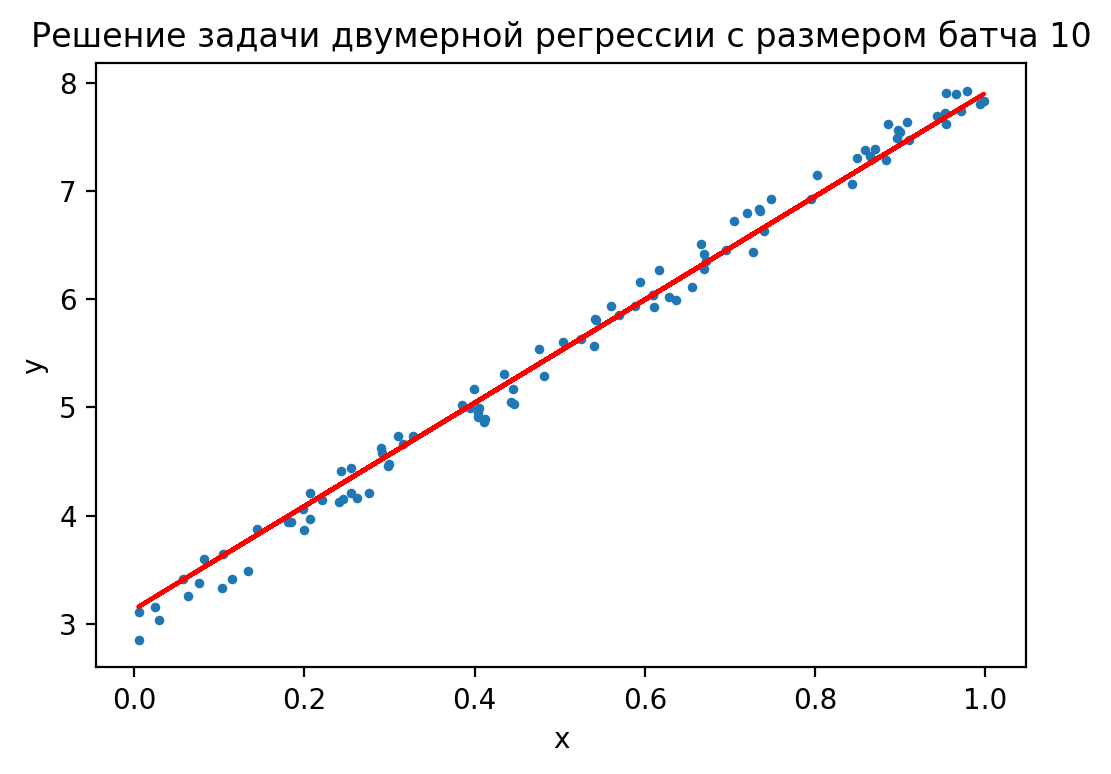

In [4]:
X_2_dim, Y_2_dim = generate_points(np.array([[5]]), np.array([[3]]), n=1, m=100, noise=0.2)
x_2_dim = X_2_dim.ravel()
y_2_dim = Y_2_dim.ravel()
model = LinearRegression(1)
optimize_model(model, ConstantStepOptimizer(0.01, model), X_2_dim, Y_2_dim, batch_size=10, max_epoch=1000, eps=0.0001)
k_2_dim = model.w[0][0]
b_2_dim = model.b[0][0]
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.set_title(r"Решение задачи двумерной регрессии с размером батча 10")
ax.scatter(x_2_dim, y_2_dim, s=6)
ax.plot(x_2_dim, model.predict(X_2_dim).ravel(), 'r', label=f"y = {k_2_dim}x + {b_2_dim}")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

Исследуем сходимость градиентного спуска с шагом $\alpha = 0.01$ в зависимости от размера батча на примере задачи линейной регрессии, где $n = 20$ и $m = 100$. 

Для этого рассмотрим функцию $g(x_1 \ldots x_n) = 2.5 + \sum_{i = 0}^{i = 19} \frac{i}{10} x_i$ - зависимость которую, необходимо восстановить.

Сгенерируем случайный набор векторов $X = (x_1 \ldots x_m)$, а набор чисел $Y = (y_1 \ldots y_m)$, получим как $y_i = g(x_i) + \epsilon_i$, где $\epsilon_i$ - случайное числи из интервала $[-0.5, 0.5]$.

Далее применим метод градиентного спуска с размерами батчей от $1$ до $m$ для решения поставленной задачи, и исследуем зависимость значения функции ошибки и количество итераций необходимых для сходимости в зависимости от размера батча.

In [5]:
retry = 10
n = 20
m = 100
c = np.array([i / 10 for i in range(n)]).reshape((-1, 1))
b = np.array([2.5])
X, Y = generate_points(c, b, n, m)


def run_one_time(optim_provider, batch_size):
    model = LinearRegression(n)
    optim = optim_provider(model)

    start = time.time()
    _, it_cnt = optimize_model(model, optim, X, Y, batch_size=batch_size, max_epoch=1000, eps=0.001)
    end = time.time()
    return it_cnt, model.update(X, Y), (end - start) * 1000, 

def run_with_retry(optim_provider, batch_size):
    result = np.array(run_one_time(optim_provider, batch_size), dtype=object)
    for _ in range(retry - 1):
         result += np.array(run_one_time(optim_provider, batch_size), dtype=object)
    return result / retry

def run_every_batch(optim_provider):
        stat = run_with_retry(optim_provider, 1).reshape((1, -1))
        for batch_size in range(2, m + 1):
            stat = np.vstack((stat, run_with_retry(optim_provider, batch_size)))
        return stat.T

constant_step = lambda model: ConstantStepOptimizer(0.01, model)

In [6]:
it_constant, loss_constant, time_constant = run_every_batch(constant_step)

Зависимость количества итераций необходимых для сходимости в зависимости от размера батча:

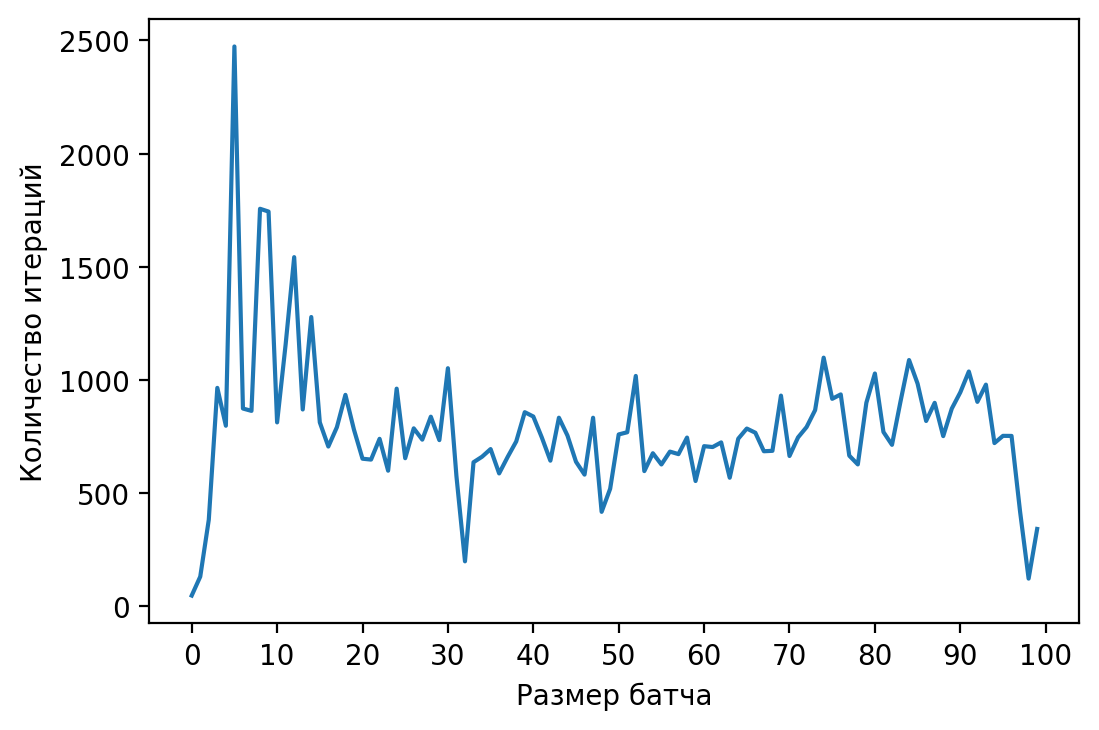

In [7]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(it_constant)
ax.set_xlabel("Размер батча")
ax.set_ylabel("Количество итераций")
ax.set_xticks(np.arange(0, 101, 10))
plt.show()

Зависимость итоговой функции ошибки в зависимости от размера батча:

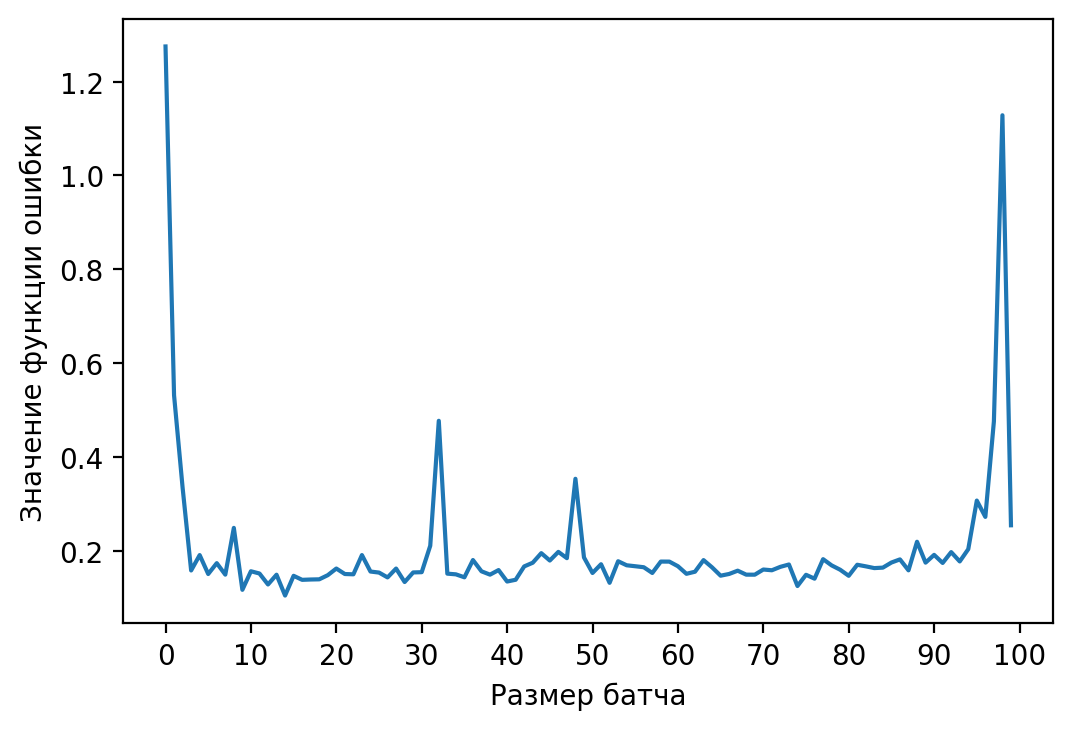

In [8]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(loss_constant)
ax.set_xlabel("Размер батча")
ax.set_ylabel("Значение функции ошибки")
ax.set_xticks(np.arange(0, 101, 10))
plt.show()

На основе полученных данных, можно сделать вывод, что наибольшее значение значение функции ошибки достигается при размере батча близком к минимально или максимально возможному 
(для размеров батчей близких к максимальному значению данный эффект может быть связан наличием шума $\epsilon$ в наборе чисел $Y$). 
Для промежуточных значений, значение ошибки практически одинаково, для всех размеров батчей (за исключением нескольких пиков в которых значение больше).
При этом, начиная с размера батча равному 50 значение функции ошибки не возрастает, а количество итераций лежит в интервале от 500 до 1000 и не уменьшается с увеличением размера батча.
То есть, выбрав размер батча равный 50, можно получить эквивалентное значение функции ошибки, что и для больших размеров батчей, при этом количество итераций останется тем же, а значит уменьшится время сходимости, так как
обработка батча меньшего размера занимает меньше времени.

Таким образом, можно сформулировать вывод:

Батчевый градиентный спуск позволяет ускорить сходимость градиентного спуска, не потеряв при этом точности решения.

## Градиентный спуск с функцией изменения шага

Рассмотрим стохастический градиентный спуск со ступенчатой функцией шага, а именно:

Значение шага на итерации $it$ равняется $\alpha = max(\alpha_{min}, \alpha_{start} - it \cdot decay)$, $\alpha_{min}$ - минимальное значение шага, $\alpha_{start}$ - начальное значение шага, $decay$ - величина уменьшения шага на каждой итерации.

Данная модификация позволяет выбрать стартовое значение шага, большее чем в градиентном спуске с постоянным шагом, за счёт чего улучшить сходимость на первых итерациях, а также уменьшить значение шага на более поздних итерациях.

Исследуем итераций необходимых для сходимости стохастическому градиентному спуску со ступенчатой функций с параметрами:

* $\alpha_{min} = 0.001$
* $\alpha_{start} = 0.1$
* $decay = 0.001$

по сравнению с стохастическим градиентным спуском с постоянным шагом равным $0.01$. 

In [9]:

decay = lambda model: DecayStepOptimizer(alpha=0.1, decay=0.001, model=model)

In [10]:
it_decay, loss_decay, time_ = run_every_batch(decay)

Cравним значение функции ошибки в зависимости от размера батча для градиентного спуска с постоянным шагом и для градиентного шага со ступенчатой функцией шага.

График зависимости функции ошибки от размера батча

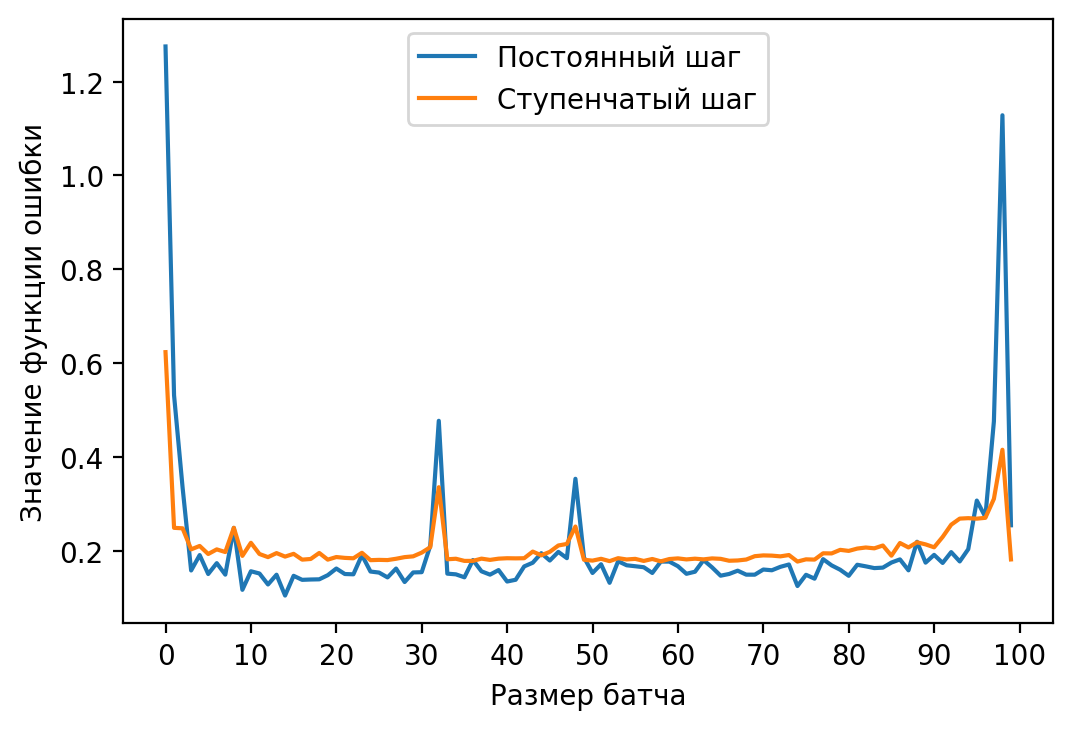

In [11]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(loss_constant, label="Постоянный шаг")
ax.plot(loss_decay, label="Ступенчатый шаг")
ax.set_xlabel("Размер батча")
ax.set_ylabel("Значение функции ошибки")
ax.set_xticks(np.arange(0, 101, 10))
ax.legend()
plt.show()

Из полученных данных, можно сделать вывод, что значение функции ошибки для градиентного спуска со ступенчатым шагом близко к значению функции ошибки для градиентного спуска с постоянным шагом, для всех размеров батчей.

Рассмотрим количество итераций, необходимых для сходимости.

График зависимости количества итераций от размера батча:

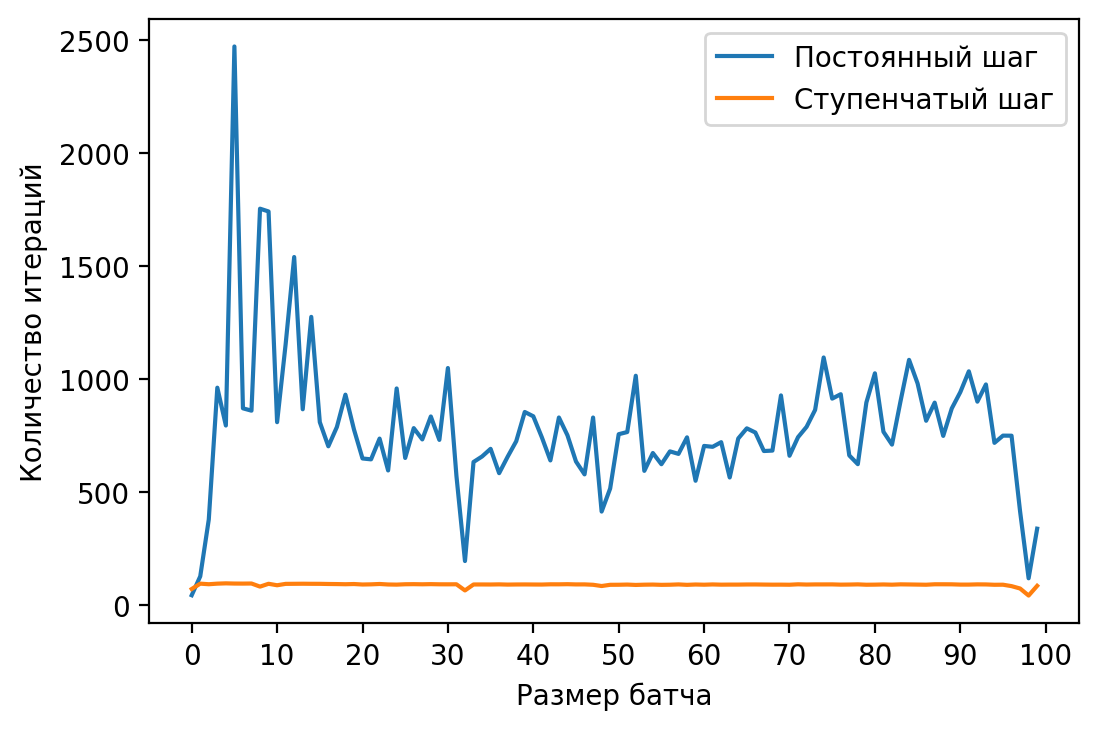

In [13]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(it_constant, label="Постоянный шаг")
ax.plot(it_decay, label="Ступенчатый шаг")
ax.set_xlabel("Размер батча")
ax.set_ylabel("Значение функции ошибки")
ax.set_xlabel("Размер батча")
ax.set_ylabel("Количество итераций")
ax.set_xticks(np.arange(0, 101, 10))
ax.legend()
plt.show()

Из полученных данных, можно сделать вывод, что количество итераций необходимых для сходимости градиентному спуску со ступенчатым шагом значительно меньше, чем количество итераций необходимых градиентному спуску с постоянным шагом.

Таким образом можно сделать вывод:

Применение функции изменения шага в градиентном спуске, позволяет уменьшить количество итераций необходимых для сходимости, не потеряв при этом точности решения.

# Модификации градиентного спуска

Рассмотрим модификации градиентного спуска, направленные на улучшение его сходимости.

1. Momentum

    Данный метод использует экспоненциальное сглаживание для значения градиента, после сглаженный градиент используется для обновления точки минимума.

    $v_{i+1} = \gamma v_i + (1 - \gamma) \nabla f(w_i)$ - сглаженное значение градиента

    $w_{i+1} = w_i - \alpha v_{i + 1}$ - обновление точки минимума

    Будем рассматривать данный метод с $\alpha = 0.065$ и $\gamma = 0.9$.

2. Nesterov

    Данный метод использует экспоненциальное сглаживание для значения градиента, но в отличие от Momentum значение градиента берется в точке, в которую градиентный спуск бы попал используя
    предыдущее значение градиента.

    $v_{i + 1} = \gamma v_i + (1-\gamma)  \nabla f(w_i - \alpha \gamma v_i)$ - сглаженное значение градиента

    $w_{i+1} = w_i - \alpha v_{i + 1}$ - обновление точки 
    
     Будем рассматривать данный метод с $\alpha = 0.065$ и $\gamma = 0.9$.
3. AdaGrad

    Данный метод накапливает значение квадрата градиента, и делит шаг $\alpha$ на величину обратную корню накопленного значения, что позволяет обновлять с большим коэффицентом, 
    значение тех переменные, по которым значение градиента мало.

    $G_{i+1} = G_i + \nabla f(w_i) \nabla f(w_i)^T$ - накопление квадрата градиента

    $w_{i+1} = w_i - \alpha \frac{\nabla f(w_i)}{\sqrt diag(G_{i+1})}$ - обновление точки минимума
    
    Будем рассматривать данный метод с $\alpha = 2$.

4. RMSProp

    Данный метод использует экспоненциальное сглаживание для квадрата градиента. 
    
    Далее, шаг делится на корень из сглаженного квадрата градиента, аналогично AdaGrad.

    $s_{i+1} = \gamma s_i + (1 - \gamma) \nabla f(w_i)^2$ - накопление квадрата градиента

    $w_{i+1} = w_i - \alpha \frac{\nabla f(w_i)}{\sqrt s_{i+1}}$ - обновление точки минимума

    Будем рассматривать данный метод с $\alpha = 0.065$ и $\gamma = 0.99$.

5. Adam

    Данный метод использует экспоненциальное сглаживание для градиента и квадрата градиента и использует их для обновления объединяя идеи предыдущих алгоритмов.

    $v_{i+1} = \beta_1 v_i + (1 - \beta_1) \nabla f(w_i)$ - сглаженное значение градиента

    $s_{i+1} = \beta_2 s_i + (1 - \beta_2) \nabla f(w_i)^2$ - накопление квадрата градиента

    $v'_{i+1} = \frac{v_{i+1}}{1 - \beta_1^{i+1}}$
    
    $s'_{i+1} = \frac{s_{i+1}}{1 - \beta_2^{i+1}}$

    $w_{i+1} = w_i - \alpha \frac{v'_{i+1}}{\sqrt s'_{i+1}}$ - обновление точки минимума

    Будем рассматривать данный метод с $\alpha = 0.065$, $\beta_1 = 0.9$, $\beta_2 = 0.99$.

Cравним данные методы на примере функции

$f(x, y) = \sum_{i = 1}^{i = 19}{\frac{1}{19}(1.5 - x + xy)^2} + \sum_{i = 1}^{i = 8}{\frac{1}{8}(1.5 - x + xy^2)^2} + \sum_{i = 1}^{i = 3}{\frac{1}{3}(1.5 - x + xy^3)^2}$

c точкой минимума равной $(3, 0.5)$. Стартовую точку установим равной $(1.5, 2.3)$


In [19]:
n = 2
f_1_sqrt = lambda x: 1.5 - x[0] + x[0] * x[1]
f_1 = lambda x: f_1_sqrt(x) ** 2
grad_f_1 = lambda x: 2 * f_1_sqrt(x) * np.array([-1 + x[1], x[0]])

f_2_sqrt = lambda x: 2.25 - x[0] + x[0] * x[1] * x[1]
f_2 = lambda x: f_2_sqrt(x) ** 2
grad_f_2 = lambda x: 2 * f_2_sqrt(x) * np.array([-1 + x[1] * x[1], 2 * x[0] * x[1]])

f_3_sqrt = lambda x: 2.625 - x[0] + x[0] * x[1] * x[1] * x[1]
f_3 = lambda x: f_3_sqrt(x) ** 2
grad_f_3 = lambda x: 2 * f_3_sqrt(x) * np.array([-1 + x[1] * x[1] * x[1], 3 * x[0] * x[1] * x[1]])

f = lambda x: f_1(x) + f_2(x) + f_3(x)

scale_1 = 19
scale_2 = 8
scale_3 = 3
scale = scale_1 + scale_2 + scale_3
functions = [lambda x: f_1(x) / scale_1 for _ in range(scale_1)] + [lambda x: f_2(x) / scale_2 for _ in range(scale_2)] + [lambda x: f_2(x) / scale_3 for _ in range(scale_3)]
grads = [lambda x: grad_f_1(x) / scale_1 for _ in range(scale_1)] + [lambda x: grad_f_2(x) / scale_2 for _ in range(scale_2)] + [lambda x: grad_f_3(x) / scale_3 for _ in range(scale_3)]
point = np.array([1.5, 2.3])
argmin = np.array([3, 0.5])
retry = 5

def sum_optimiziation_history(optim_provider, batch_size, point=point, max_epoch=5000, eps=0.00005):
     _, _, _, history = optimize_sum_functions(n, functions, grads, point, optim_provider, batch_size, max_epoch=max_epoch, eps=eps, trace_history=True)
     return np.array(history)

def sum_optimiziation_argmin(optim_provider, batch_size, point=point, max_epoch=5000, eps=0.00005):
     argmin, _, _ = optimize_sum_functions(n, functions, grads, point, optim_provider, batch_size, max_epoch=max_epoch, eps=eps)
     return argmin


def run_sum_ones(optim_provider, batch_size, point=point, max_epoch=5000, eps=0.00005):
    start = time.time()
    tracemalloc.start()
    argmin, epoch_cnt, _ = optimize_sum_functions(n, functions, grads, point, optim_provider, batch_size, max_epoch=max_epoch, eps=eps)
    _, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = time.time()
    return argmin, epoch_cnt, (end - start) * 1000, peak_mem

def run_sum_with_retry(optim_provider, batch_size, point=point):
    result = np.array(run_sum_ones(optim_provider, batch_size), dtype=object)
    for _ in range(retry - 1):
         result += np.array(run_sum_ones(optim_provider, batch_size, point), dtype=object)
    return result / retry

def run_sum_every_batch(optim_provider):
        stat = run_sum_with_retry(optim_provider, 2).reshape((1, -1))
        for batch_size in range(3, scale + 1):
            stat = np.vstack((stat, run_sum_with_retry(optim_provider, batch_size)))
        return stat.T

momentum = lambda model: Momentum(alpha=0.065, gamma=0.9, model=model)
nesterov = lambda model: Nesterov(alpha=0.065, gamma=0.9, model=model)
adaGrad = lambda model: AdaGrad(alpha=2, model=model)
rmsProp = lambda model: RMSProp(alpha=0.065, gamma=0.99, model=model)
adam = lambda model: Adam(alpha=0.065, b1=0.9, b2=0.99, model=model)

## Скорость сходимости

Исследуем скорость сходимости методов с точки зрения количества эпох, необходимых для сходимости в зависимости от размера батча. 
Для этого, запустим каждый из описанных методов на размере батча от 2 до 30 по 5 раз, полученные данные усредним.

In [15]:
argmin_momentum, epoch_momentum, time_momentum, memory_momentum = run_sum_every_batch(momentum)
argmin_nesterov, epoch_nesterov, time_nesterov, memory_nesterov = run_sum_every_batch(nesterov)
argmin_adaGrad, epoch_adaGrad, time_adaGrad, memory_adaGrad = run_sum_every_batch(adaGrad)
argmin_rmsProp, epoch_rmsProp, time_rmsProp, memory_rmsProp = run_sum_every_batch(rmsProp)
argmin_adam, epoch_adam, time_adam, memory_adam = run_sum_every_batch(adam)

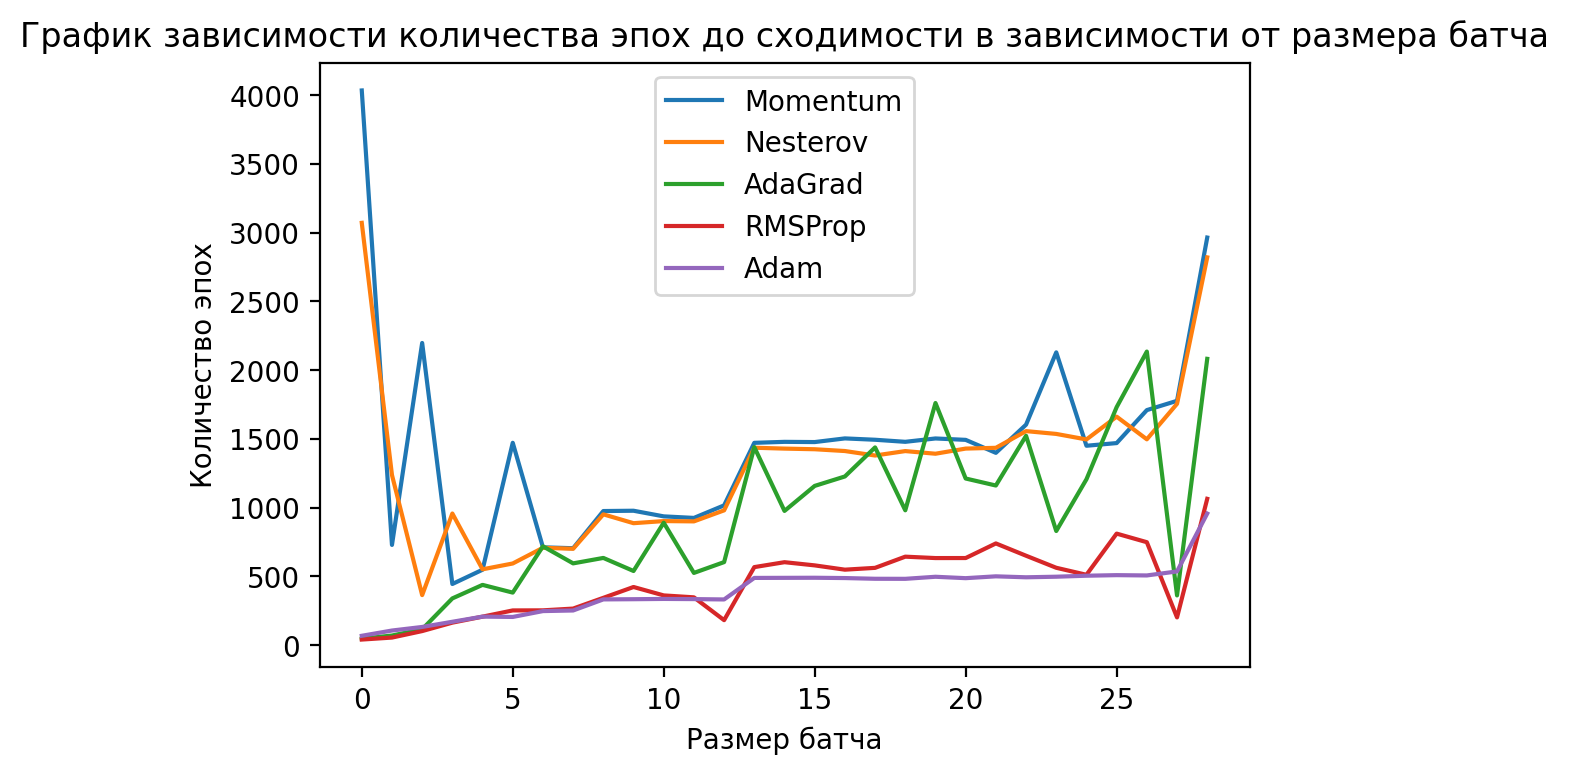

In [16]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(epoch_momentum, label="Momentum")
ax.plot(epoch_nesterov, label="Nesterov")
ax.plot(epoch_adaGrad, label="AdaGrad")
ax.plot(epoch_rmsProp, label="RMSProp")
ax.plot(epoch_adam, label="Adam")
ax.set_xlabel("Размер батча")
ax.set_ylabel("Количество эпох")
ax.set_title("График зависимости количества эпох до сходимости в зависимости от размера батча")
ax.legend()
plt.show()

На основе полученных данных, можно сделать вывод, что методы Momentum, Nesterov и AdaGrad требуют наибольшее количество эпох для сходимости, а RMSProp и Adam наименьшее количество эпох.

## Надежность методов

Исследуем надежность методов с точки зрения достижения точки минимума в зависимости от выбора начальной точки. 
Для этого запустим каждый из описанных методов из начальных точек на квадратной сетке, с границами по $x$ и $y$ равными $-3.5$ и $3.5$, размером 10 на 10. 
Для каждого метода посчитаем в скольких случаях итоговая точка будет лежать в окрестности точки минимума равной $(3, 0.5)$ c радиусом 0.1.

Результаты эксперимента приведены в таблице:

In [20]:
def points_on_grid():
    t = np.linspace(-3, 3, 10)
    x, y = np.meshgrid(t, t)
    return np.vstack([x.ravel(), y.ravel()]).T

def achieved_count(optmizer_provider):
    return sum([np.sqrt(np.sum((argmin - sum_optimiziation_argmin(optmizer_provider, 10, point=p)) ** 2)) < 0.1 for p in points_on_grid()])

achieved_count_momentum = achieved_count(momentum)
achieved_count_nesterov = achieved_count(nesterov)
achieved_count_adaGrad = achieved_count(adaGrad)
achieved_count_rmsProp = achieved_count(rmsProp)
achieved_count_adam = achieved_count(adam)

In [22]:
table = pd.DataFrame(
    index=["Количество итераций"], 
    data =
    {
        "Momentum": [achieved_count_momentum],
        "Nesterov": [achieved_count_nesterov],
        "AdaGrad": [achieved_count_adaGrad],
        "RMSProp": [achieved_count_rmsProp],
        "Adam": [achieved_count_adam],
    }
)
df_to_markdown(table, "Метод")

Метод|Momentum|Nesterov|AdaGrad|RMSProp|Adam
---|---|---|---|---|---
Количество итераций|55|57|63|68|67


На основе полученных данных, можно сделать вывод что самыми надежными методами являются Adam и RMSProp, а самыми ненадежными Momentum и Nesterov.

## Время исполнения

Для оценки времени исполнения рассмотрим время необходимое на одну эпоху в зависимости от размера батча. Для этого, запустим каждый из описанных методов на размере батча от 1 до 30 по 5 раз, усредним данные по количеству эпох и общему количеству миллисекунд, а затем посчитаем отношение среднего количества миллисекунд к среднему количеству эпох.

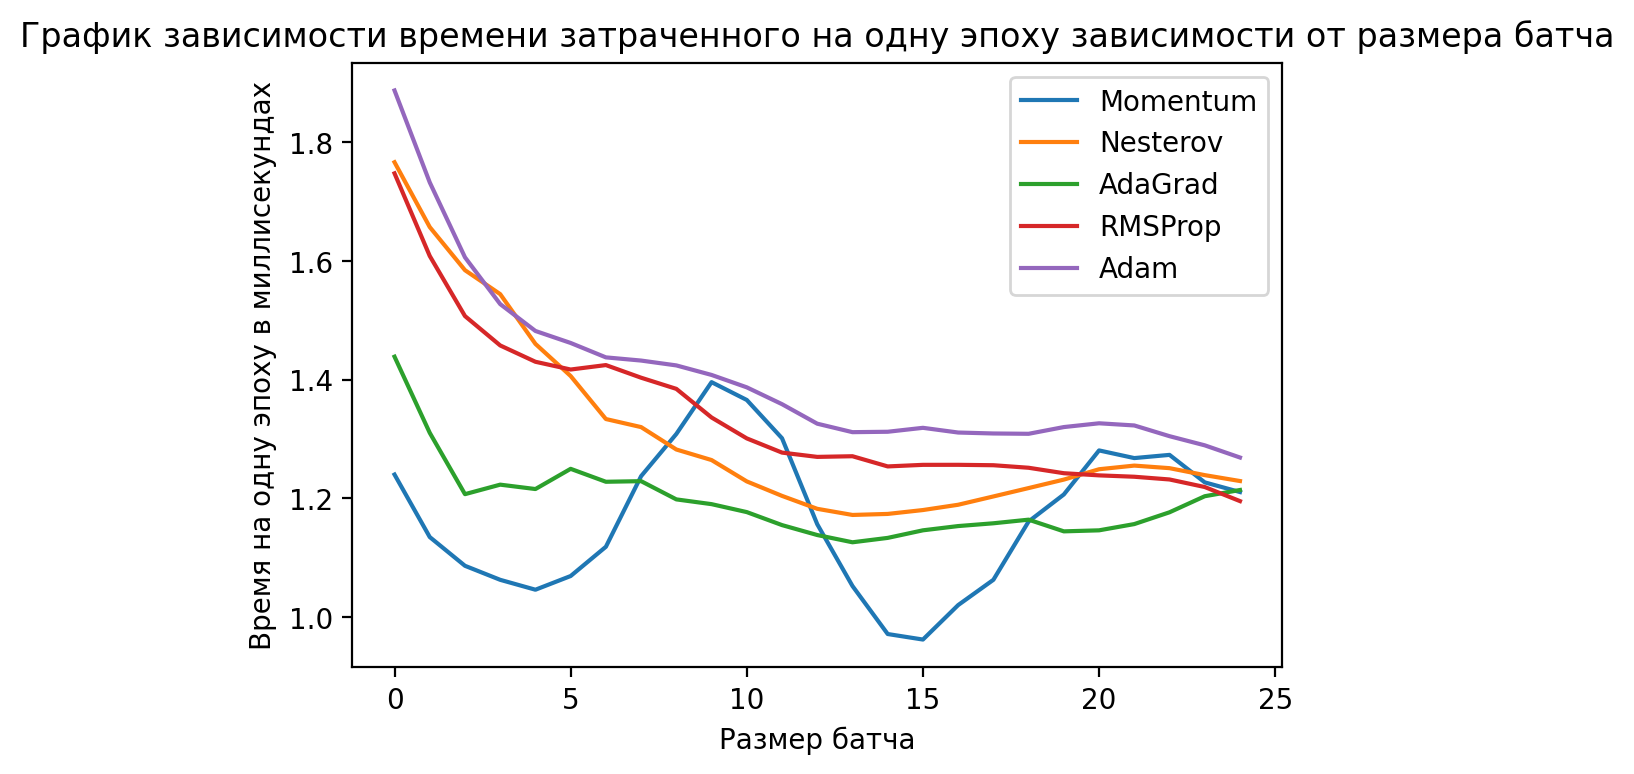

In [28]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
epoch_time_momentum = time_momentum / epoch_momentum
epoch_time_nesterov = time_nesterov / epoch_nesterov
epoch_time_adaGrad = time_adaGrad / epoch_adaGrad
epoch_time_rmsProp = time_rmsProp / epoch_rmsProp
epoch_time_adam = time_adam / epoch_adam
ax.plot(conv(epoch_time_momentum), label="Momentum")
ax.plot(conv(epoch_time_nesterov), label="Nesterov")
ax.plot(conv(epoch_time_adaGrad), label="AdaGrad")
ax.plot(conv(epoch_time_rmsProp), label="RMSProp")
ax.plot(conv(epoch_time_adam), label="Adam")
ax.set_xlabel("Размер батча")
ax.set_ylabel("Время на одну эпоху в миллисекундах")
ax.set_title("График зависимости времени затраченного на одну эпоху зависимости от размера батча")
ax.legend()
plt.show()

Из полученных данных, можно сделать вывод, что методы Adam, RMSProp и Nesterov требуют наибольшего количества миллисекунд на одну эпоху, а наименьшего методы Momentum и AdaGrad.

##  Количество памяти

Исследуем максимальное количество памяти необходимое для работы каждого из методов в зависимости от размера батча. Для этого, запустим каждый из описанных методов на размере батча от 2 до 30 по 5 раз, полученные данные усредним.

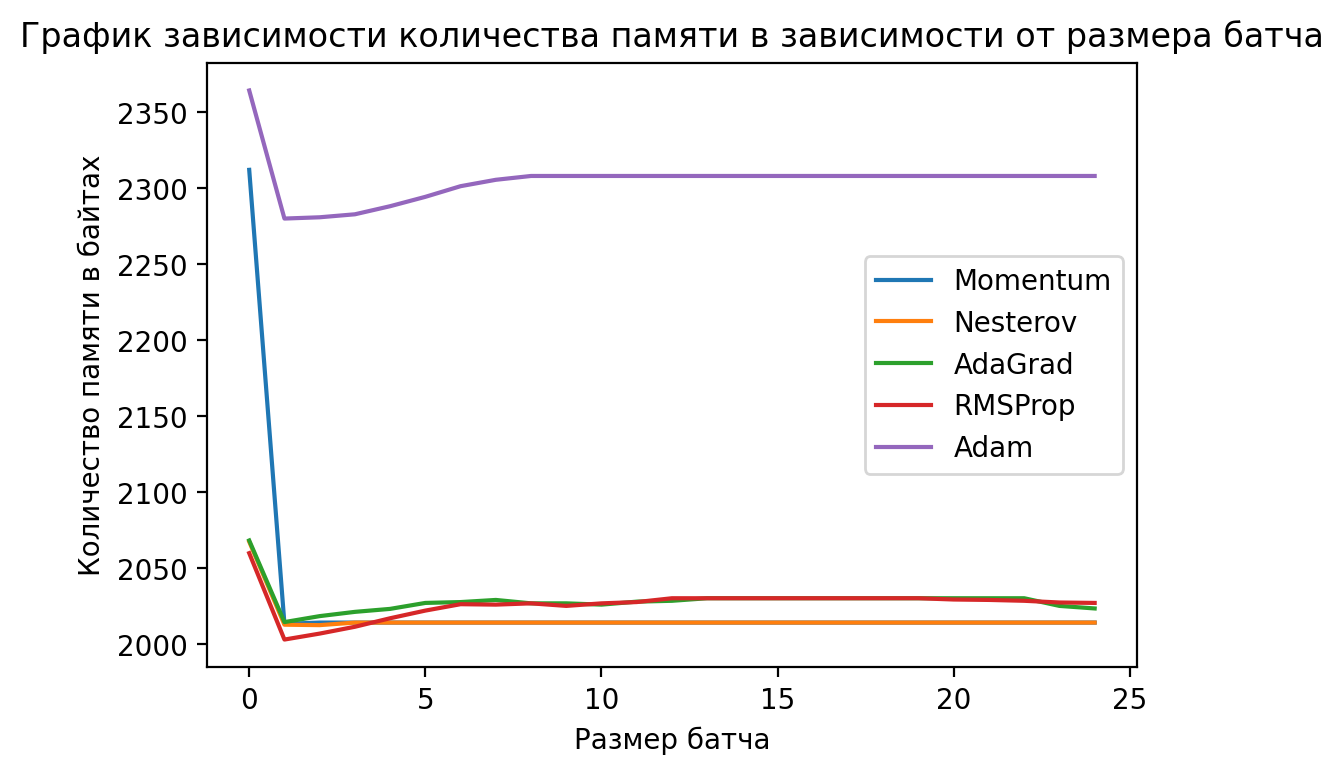

In [ ]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(conv(memory_momentum), label="Momentum")
ax.plot(conv(memory_nesterov), label="Nesterov")
ax.plot(conv(memory_adaGrad), label="AdaGrad")
ax.plot(conv(memory_rmsProp), label="RMSProp")
ax.plot(conv(memory_adam), label="Adam")
ax.set_xlabel("Размер батча")
ax.set_ylabel("Количество памяти в байтах")
ax.set_title("График зависимости количества памяти в зависимости от размера батча")
ax.legend()
plt.show()

Из полученных данных, можно сделать вывод, что количество выделенной памяти не зависит от размера батча. Наибольшее количество памяти понадобилось методу Adam, а наименьшее количество методам Nesterov и Momentum.
Методы AdaGrad и RMSProp потребляют одинаковое количество памяти, незначительно большее по сравнению с методами Nesterov и Momentum.

## Анализ траекторий

Рассмотрим траектории каждого из описанных методов с размером батча равным десяти.

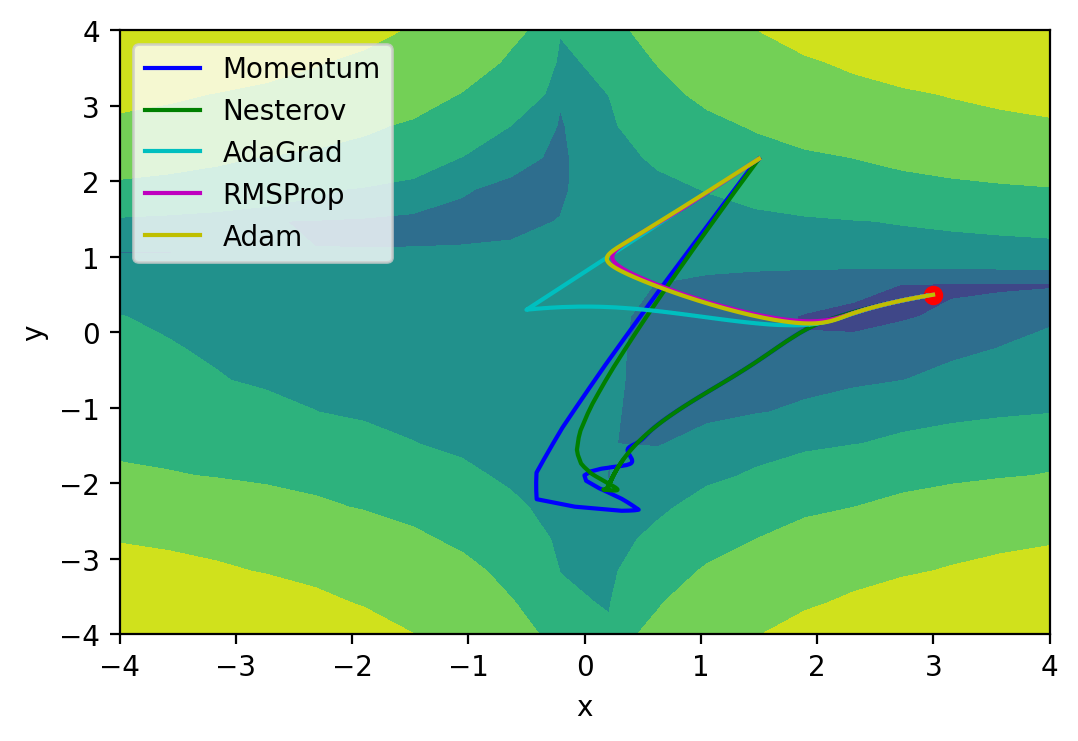

In [38]:
fig = plt.figure(dpi=200)
bs = 10
ax = fig.add_subplot()
draw_contour(ax, f, scale=(4, 4))
draw_trajectory(ax, sum_optimiziation_history(momentum, bs), label="Momentum", color='b')
draw_trajectory(ax, sum_optimiziation_history(nesterov, bs), label="Nesterov", color='g')
draw_trajectory(ax, sum_optimiziation_history(adaGrad, bs), label="AdaGrad",color='c')
draw_trajectory(ax, sum_optimiziation_history(rmsProp, bs), label="RMSProp", color='m')
draw_trajectory(ax, sum_optimiziation_history(adam, bs), label="Adam",color='y')
ax.legend(loc="upper left")
ax.scatter(argmin[0], argmin[1], c='r')
plt.show()

На приведенном графике, траектории для методов Adam и RMSProp практически совпадают. Также, Nesterov и Momentum имеют схожую траекторию на начальных итерациях, но Nesterov быстрее изменяет траекторию по направлению к точке минимума.
Adagrad, на первых итерациях делает шаги размера большего чем Adam и RMSProp, после сходится к той же траектории что и эти два метода.

## Выводы

Сформилируем общие выводы по модификация градиентного спуска

* Методы Adam и RMSProp являются самыми надежными и быстросходящиеся методы, при это требующие большее количество машинных ресурсов.
* Метод Momentum является наиболее оптимальным по машинным ресурсам, при этом менее надеждным и быстросходящимся.
* Метод AdaGrad является методом имеющим среднии характеристики по всем оцениваемым параметрам.
* Метод Nesterov имеет надежность и скорость сходимости на уровне метода Momentum, при этом требует большего количества машинных ресурсов.

# Полиноминальная регрессия

Пусть $X = (x_1, x_2 \ldots x_m)$ - набор чисел, $Y = (y_1, y_2 \ldots y_m)$ - набор чисел, $d$ - максимально возможная степень полинома.

Задача полиноминальной регрессии заключается в нахождении полинома $f(x)$ степени не больше $d$, минизирующего следующую функцию:

$L(w) = \sum_{i = 1}^{m}({f(x_i) - y_i})^2$. Функцию $L$ называют функцией ошибки.

Иными словами, нужно найти полином, наилучшим образом аппроксимириющий входные данные.

## Восстановление регрессии

Исследуем восстановление регрессии на примере функции

1. $f(x) = 0.3 + 0.1x - 0.5x^2 + x^3 + x^4$


Для каждой функции сгенерируем случайный набор чисел $X = (x_1 \ldots x_m)$ где $m = 50$, а набор чисел $Y = (y_1 \ldots y_m)$, получим как $y_i = g(x_i) + \epsilon_i$, где $\epsilon_i$ - 
случайное число из интервала $[-0.25, 025]$.

Далее применим метод градиентного спуска c размером батча 10 и оптимизатором Adam c параметрами $\alpha = 0.03, \beta_1 = 0.9, \beta_2=0.9$  для решения поставленной задачи, 
и исследуем зависимость между восстановлением регрессии и максимальной степенью полинома $d$.

Рассмотрим восстановление функции $f$ для максимальной степени полинома равной 9, 8, 6, 4.

In [60]:
bounds=3
f_poly = lambda x: 0.3 + 0.1 * x - 0.5 * x ** 2 + 0.1 * x ** 3 + 0.1 * x ** 4

def generate_points_polynomial(c, degree, m, bounds, noise):
    X = np.linspace(-bounds, bounds, m)
    Y = np.random.uniform(low=-noise, high=noise, size=(m, 1)) + np.vander(X, N=degree + 1, increasing=True) @ c.reshape((-1, 1))
    return X, Y.ravel()

def draw_poly(ax, X, Y, degree, reg_coef, label):
    model = PolynomialRegreesion1D(degree, reg_coef, np.random.normal(size=(degree + 1, 1)))
    optimizer = Adam(3e-3, 0.9, 0.99, model)
    optimize_model(model, optimizer, X, Y, batch_size=10, max_epoch=2000, eps=float("-inf"))
    X_draw = np.unique(np.concatenate([np.linspace(-3, 3, 50), X]))
    ax.plot(X_draw, model.predict(X_draw), label=label)
    return model

def draw_initial_poly(ax):
    ax.plot(np.linspace(-bounds, bounds, 100), f_poly(np.linspace(-bounds, bounds, 100)), label="Исходная функция")

X_poly, Y_poly = generate_points_polynomial(np.array([0.3, 0.1, -0.5, 0.1, 0.1]), degree=4, m = 100, bounds=bounds, noise=0.5)
poly_degrees = [9, 8, 6, 4]

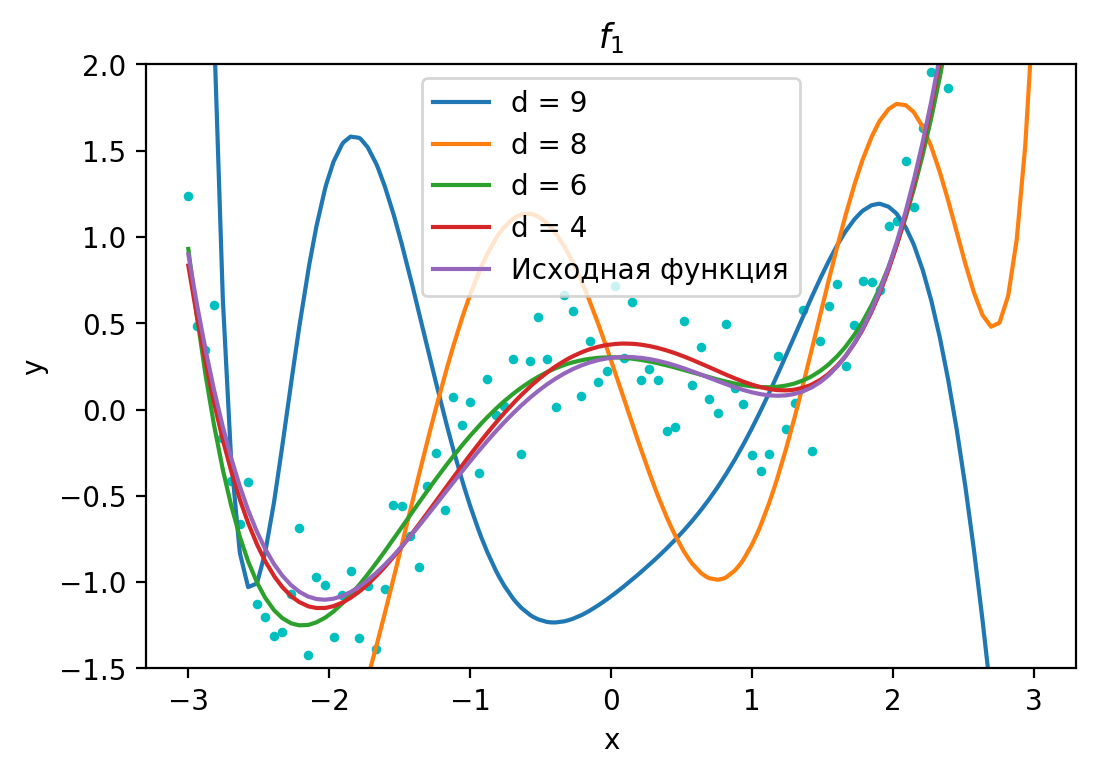

In [61]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
for degree in poly_degrees:
    draw_poly(ax, X_poly, Y_poly, degree, 0, f"d = {degree}")

draw_initial_poly(ax)
ax.scatter(X_poly, Y_poly, s=6, color="c")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(bottom=-1.5, top=2)
ax.legend()
ax.set_title("$f_1$")
plt.show()

На основе полученных данных, можно сделать вывод, что максимальных степенях полинома равных 4 и 6 исходная функция полностью восстановилась. При увеличении максимальной степени полинома, исходная зависимость перестала восстанавливаться.

# $L_2$ регуляризация

В условиях задачи полиномальной регрессии, добавим к функции ошибки регуляризацию, а именно:

$L_{reg}(w) = L(w) + \lambda ||w||_{2}^{2}$ - новая функция для минимазации.

Добавление члена $\lambda ||w||_{2}^{2}$ позволяет среди всех подходящих параметров искать параметры значение которых минимально.

Рассмотрим восстановление функции $f$ с использованием регуляризации для максимальных степеней полинома 8 и 9, с которыми восстановить полиноминальную регрессию не удалось. 

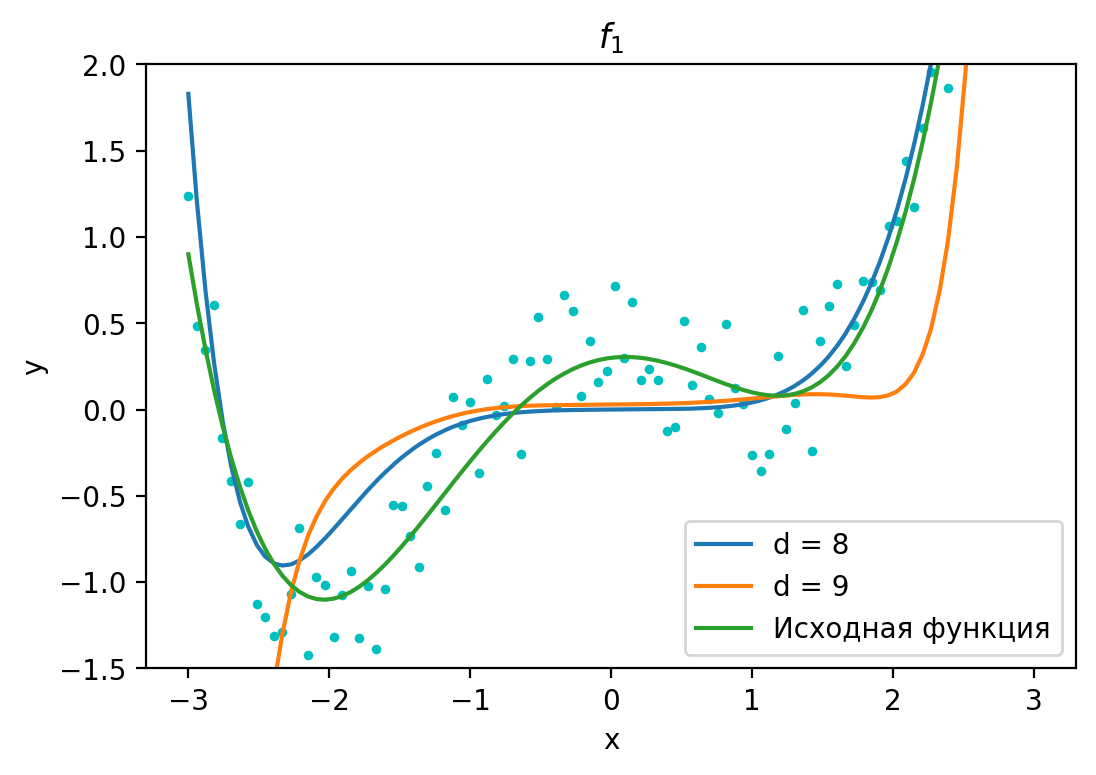

In [74]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
reg_coef = 20
for degree in [8, 9]:
    draw_poly(ax, X_poly, Y_poly, degree, reg_coef, f"d = {degree}")

draw_initial_poly(ax)
ax.scatter(X_poly, Y_poly, s=6, color="c")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(bottom=-1.5, top=2)
ax.legend()
ax.set_title("$f_1$")
plt.show()

Сравнивая текущий график, с графиком из прошлого пункта, можно заметить, что востановленная зависимость стала более похожа на исходную функцию. Таким образом можно сделать вывод, что регуляризация может быть полезной с точки зрения восстановления исходной функцию для максимальной степени полинома большей, чем в исходной зависимости.

# Выводы

В ходе работы был рассмотрен батчевый градиентный спуск для решений задачи линейной регрессии c постоянным шагом и ступенчатым шагом, различные модификации градиентного спуска направленные на улучшение сходимости и влияние регуляризации для решения задачи полиноминальной регрессии.

Сформулируем общие выводы:

1. Батчевый градиентный спуск с позволяет ускорить сходимость градиентного спуска, не потеряв при это точности решения.
2. Изменение шага градиетного спуска ступенчатой функций позволяет ускорить сходимость метода.
3. Среди модификаций градиетного спуска наиболее надежными являются RMSProp и Adam, наименее требовательной по машинным ресурсам - Momentum.
4. Регуляризация помогает восстанавливать полиномальную зависимость, если максимальное значение степени полинома выбрано больше чем в исходной зависимости.